In [1]:
from griddify import datasets

data = datasets.get_compound_descriptors()

In [2]:
from griddify import Preprocessing

pp  = Preprocessing()
pp.fit(data)
data = pp.transform(data)

In [3]:
from griddify import FeatureDistances

fd = FeatureDistances(metric="cosine").calculate(data)

In [4]:
from griddify import Tabular2Cloud


tc = Tabular2Cloud()
tc.fit(fd)
Xc = tc.transform(fd)


/home/mduranfrigola/miniconda3/envs/tab2grid/lib/python3.7/site-packages/umap/umap_.py:1780: UserWarning: using precomputed metric; inverse_transform will be unavailable
  warn("using precomputed metric; inverse_transform will be unavailable")


In [5]:
from griddify.plots import cloud_plot

<AxesSubplot:>

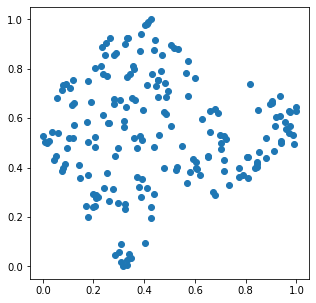

In [6]:
cloud_plot(Xc)

In [7]:
from griddify import Cloud2Grid

cg = Cloud2Grid(max_side=128)
cg.fit(Xc)
Xg = cg.transform(Xc, as_integers=False)

<AxesSubplot:>

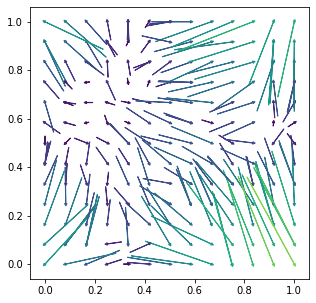

In [8]:
from griddify.plots import arrows_plot

arrows_plot(Xc, Xg, capping_distance=0.5)

In [9]:
from griddify import Cloud2Grid

cg = Cloud2Grid(max_side=128)
cg.fit(Xc)
mappings, side = cg.get_mappings(Xc)

In [10]:
from griddify import Flat2Grid

tg = Flat2Grid(mappings, side)
Xi = tg.transform(data)

<AxesSubplot:>

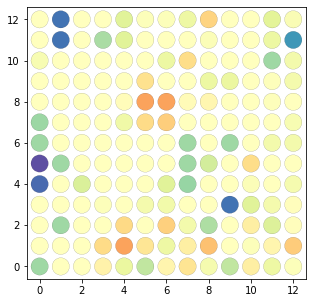

In [11]:
from griddify.plots import grid_plot

grid_plot(Xi[0])